In [1]:
import geopandas as gpd
from shapely.geometry.collection import GeometryCollection
from osgeo import osr, gdal
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import gcf
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sns
import numpy as np
import georasters as gr

/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Load Data:

elevation_t = gr.from_file('Data/Elevation_AD.TIF')
elevation_df = elevation_t.to_pandas()

soa_shape_map_path = r"Data/UAE_habitats_new1.shp"
soa_shape_map = gpd.read_file(soa_shape_map_path)
# set the null geometries to be empty geometryCollections to avoid error
soa_shape_map['geometry'] = soa_shape_map.geometry.apply(lambda x: x if x else GeometryCollection())
soa_shape_map_geo = soa_shape_map.to_crs({'init': 'epsg:4326'})

/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [3]:
print(type(elevation_df))
print(type(soa_shape_map_geo))

<class 'pandas.core.frame.DataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>


In [4]:
elevation_df.head(1)

,row,col,value,x,y
0,0,2347,1.0,54.651806,24.700139


In [5]:
soa_shape_map_geo.head(1)

,OBJECTID,Id,HabitatTyp,HabitatT_1,HabitatSub,HabitatS_1,RuleID,Shape_Leng,Shape_Area,Habitats,geometry
0,1,1,1000,Intertidal Habitats,1010,Mudflats And Sand Exposed At Low Tide,14,7524.321019,2.115300e+06,Intertidal Habitats,"POLYGON ((53.99011 24.13066, 53.99039 24.13065..."


1. Attempt one: work with shapefiles

In [ ]:
# took a long time to compile, but worked, no need to run it again
from shapely.geometry import Point
df = elevation_df.copy()
# combine lat and lon column to a shapely Point() object
df['geometry'] = df.apply(lambda x: Point((float(x.x), float(x.y))), axis=1)
import geopandas
df = geopandas.GeoDataFrame(df, geometry='geometry')

In [ ]:
df.to_file('Data/MyGeometries.shp', driver='ESRI Shapefile')

In [6]:
elevation_shpf = gpd.read_file('Data/MyGeometries.shp')
elevation_shpf

,row,col,value,x,y,geometry
0,0,2347,1.0,54.651806,24.700139,POINT (54.65181 24.70014)
1,0,2348,0.0,54.652084,24.700139,POINT (54.65208 24.70014)
2,0,2349,1.0,54.652361,24.700139,POINT (54.65236 24.70014)
3,0,2350,1.0,54.652639,24.700139,POINT (54.65264 24.70014)
4,0,2351,2.0,54.652917,24.700139,POINT (54.65292 24.70014)
...,...,...,...,...,...,...
1786761,1757,2516,37.0,54.698750,24.212083,POINT (54.69875 24.21208)
1786762,1757,2517,36.0,54.699028,24.212083,POINT (54.69903 24.21208)
1786763,1757,2518,37.0,54.699306,24.212083,POINT (54.69931 24.21208)
1786764,1757,2519,38.0,54.699584,24.212083,POINT (54.69958 24.21208)


<AxesSubplot:>

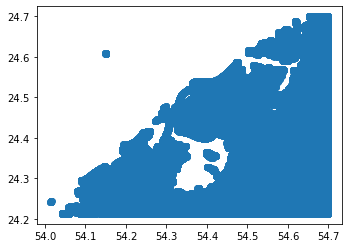

In [9]:
# this took a long time to compile/ load, but worked
elevation_shpf.plot()

In [7]:
type(elevation_shpf)

geopandas.geodataframe.GeoDataFrame

1. Attempt One:

In [8]:
# Error with sjoin because the data frames had different CRSs: Goal: make both DFs have the same CRN:
# 1. Must set a CRS for elevation data frame first
elevation_shpf = elevation_shpf.set_crs("EPSG:4326")
# elevation_shpf = elevation_shpf.set_crs(epsg=4326) # Same but different structure

In [9]:
# 2. Use .to_crs() to make the elevation df have the same CRS as the habitat df:
elevation_shpf_crs = elevation_shpf.to_crs({'init': 'epsg:4326'})

/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [28]:
# did not finish compiling, took too long.
# works & is faster than overlay but doesnt include OG columns, therefore must use [ test_habit.columns ]
combined = gpd.sjoin(test_elev, test_habit, how="left", op="intersects")
# combined = gpd.sjoin(test_elev, test_habit, how="left", op="overlaps")
# drop the NaN values, as t hey are where there was no intersection:
combined.dropna()
combined = combined[ test_habit.columns ] 

In [29]:
combined.head(1)

,OBJECTID,Id,HabitatTyp,HabitatT_1,HabitatSub,HabitatS_1,RuleID,Shape_Leng,Shape_Area,Habitats,geometry
0,25179,25183,9000,"Urban, Industrial And Commercial Habitat Types",9230,Port Areas,49,6946.566553,656876.971787,Developed,POINT (54.65181 24.70014)


<AxesSubplot:>

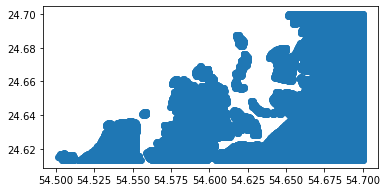

In [30]:
combined.plot()

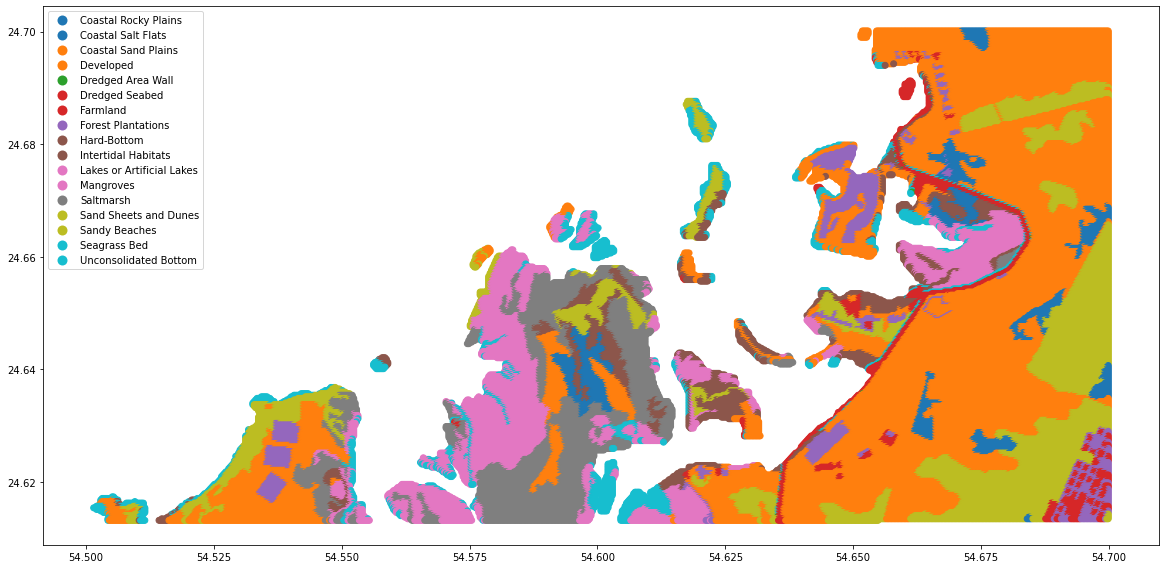

In [31]:
combined.plot(column='Habitats', legend='True')
fig = plt.gcf()
fig.set_size_inches(20, 14)

2. Attempt two:

In [10]:
print(len(elevation_shpf_crs))
print(len(soa_shape_map_geo))

1786766
68412


In [27]:
# to select multiple rows
test_elev = elevation_shpf_crs.iloc[:90000]
test_habit = soa_shape_map_geo.iloc[:90000]

In [15]:
# Taking too long because the data frames are too huge
# This was an attempt where I took only 40000 values, this is why its is less accurate and maps a smaller region
overlay = gpd.overlay(test_elev, test_habit, how='intersection')
# NaN values are where there was no intersections:
overlay.dropna()

,row,col,value,x,y,OBJECTID,Id,HabitatTyp,HabitatT_1,HabitatSub,HabitatS_1,RuleID,Shape_Leng,Shape_Area,Habitats,geometry
0,0,2347,1.0,54.651806,24.700139,25179,25183,9000,"Urban, Industrial And Commercial Habitat Types",9230,Port Areas,49,6946.566553,656876.971787,Developed,POINT (54.65181 24.70014)
1,0,2348,0.0,54.652084,24.700139,25179,25183,9000,"Urban, Industrial And Commercial Habitat Types",9230,Port Areas,49,6946.566553,656876.971787,Developed,POINT (54.65208 24.70014)
2,0,2349,1.0,54.652361,24.700139,25179,25183,9000,"Urban, Industrial And Commercial Habitat Types",9230,Port Areas,49,6946.566553,656876.971787,Developed,POINT (54.65236 24.70014)
3,0,2350,1.0,54.652639,24.700139,25179,25183,9000,"Urban, Industrial And Commercial Habitat Types",9230,Port Areas,49,6946.566553,656876.971787,Developed,POINT (54.65264 24.70014)
4,0,2351,2.0,54.652917,24.700139,25179,25183,9000,"Urban, Industrial And Commercial Habitat Types",9230,Port Areas,49,6946.566553,656876.971787,Developed,POINT (54.65292 24.70014)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36948,199,2327,1.0,54.646250,24.644861,227,228,1000,Intertidal Habitats,1020,Sheltered Tidal Flats With Cyanobacterial Mats,15,2245.946159,141439.394379,Intertidal Habitats,POINT (54.64625 24.64486)
36949,199,2328,-1.0,54.646528,24.644861,227,228,1000,Intertidal Habitats,1020,Sheltered Tidal Flats With Cyanobacterial Mats,15,2245.946159,141439.394379,Intertidal Habitats,POINT (54.64653 24.64486)
36950,200,2327,1.0,54.646250,24.644583,227,228,1000,Intertidal Habitats,1020,Sheltered Tidal Flats With Cyanobacterial Mats,15,2245.946159,141439.394379,Intertidal Habitats,POINT (54.64625 24.64458)
36951,200,2328,-1.0,54.646528,24.644583,227,228,1000,Intertidal Habitats,1020,Sheltered Tidal Flats With Cyanobacterial Mats,15,2245.946159,141439.394379,Intertidal Habitats,POINT (54.64653 24.64458)


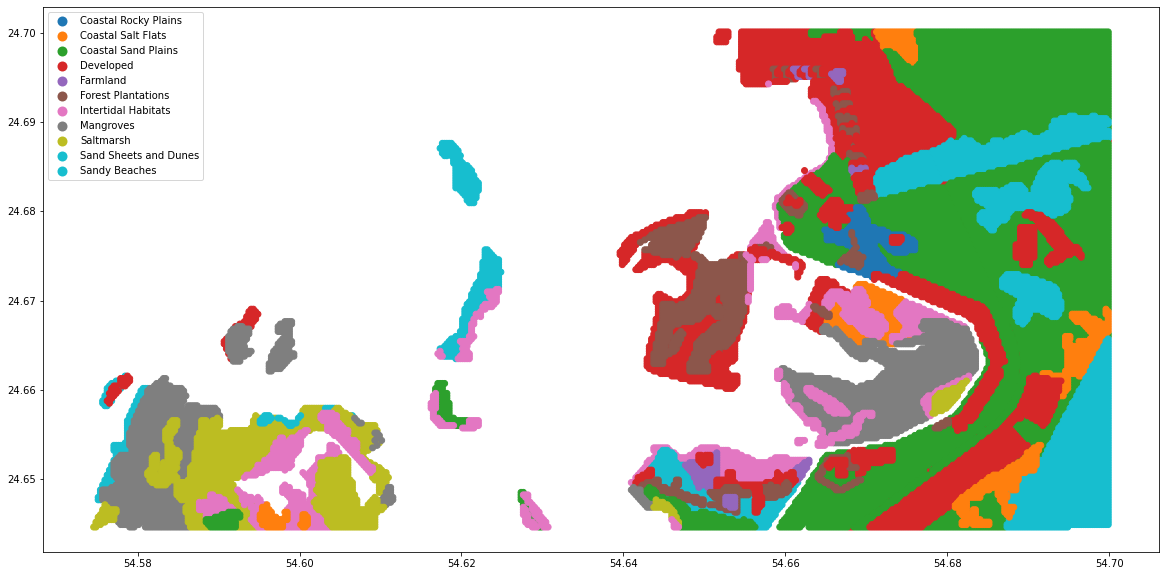

In [16]:
overlay.plot(column='Habitats', legend='True')
fig = plt.gcf()
fig.set_size_inches(20, 14)

<AxesSubplot:>

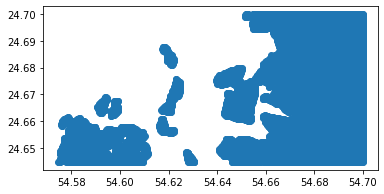

In [17]:
overlay.plot()

3. Attempt Three: ***Did not work

In [17]:
int_df = pd.merge(elevation_shpf_crs, soa_shape_map_geo, how ='inner', on=['geometry'])

In [18]:
int_df

,row,col,value,x,y,geometry,OBJECTID,Id,HabitatTyp,HabitatT_1,HabitatSub,HabitatS_1,RuleID,Shape_Leng,Shape_Area,Habitats


# Final:

# 1. gpd.sjoin()

In [11]:
final_combined = gpd.sjoin(elevation_shpf_crs, soa_shape_map_geo, how="left", op="intersects")
final_combined.dropna()
final_combined = final_combined[ soa_shape_map_geo.columns ]

<AxesSubplot:>

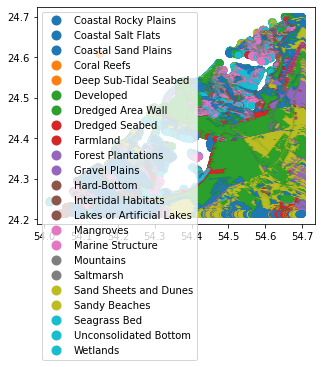

In [12]:
final_combined.plot(column='Habitats', legend='True')

In [18]:
# Should have added habitat columns first then droped NaN values:
final_combined2 = gpd.sjoin(elevation_shpf_crs, soa_shape_map_geo, how="left", op="intersects")
final_combined2 = final_combined[ soa_shape_map_geo.columns ]
final_combined2.dropna()

,OBJECTID,Id,HabitatTyp,HabitatT_1,HabitatSub,HabitatS_1,RuleID,Shape_Leng,Shape_Area,Habitats,geometry
0,25179,25183,9000,"Urban, Industrial And Commercial Habitat Types",9230,Port Areas,49,6946.566553,6.568770e+05,Developed,POINT (54.65181 24.70014)
1,25179,25183,9000,"Urban, Industrial And Commercial Habitat Types",9230,Port Areas,49,6946.566553,6.568770e+05,Developed,POINT (54.65208 24.70014)
2,25179,25183,9000,"Urban, Industrial And Commercial Habitat Types",9230,Port Areas,49,6946.566553,6.568770e+05,Developed,POINT (54.65236 24.70014)
3,25179,25183,9000,"Urban, Industrial And Commercial Habitat Types",9230,Port Areas,49,6946.566553,6.568770e+05,Developed,POINT (54.65264 24.70014)
4,25179,25183,9000,"Urban, Industrial And Commercial Habitat Types",9230,Port Areas,49,6946.566553,6.568770e+05,Developed,POINT (54.65292 24.70014)
...,...,...,...,...,...,...,...,...,...,...,...
1786761,1093,1094,3000,"Coastal Sabkha, Including Sabkha Matti",3100,"Coastal Sabkha, Including Sabkha Matti",25,31845.945331,9.305026e+06,Coastal Salt Flats,POINT (54.69875 24.21208)
1786762,1093,1094,3000,"Coastal Sabkha, Including Sabkha Matti",3100,"Coastal Sabkha, Including Sabkha Matti",25,31845.945331,9.305026e+06,Coastal Salt Flats,POINT (54.69903 24.21208)
1786763,1093,1094,3000,"Coastal Sabkha, Including Sabkha Matti",3100,"Coastal Sabkha, Including Sabkha Matti",25,31845.945331,9.305026e+06,Coastal Salt Flats,POINT (54.69931 24.21208)
1786764,1093,1094,3000,"Coastal Sabkha, Including Sabkha Matti",3100,"Coastal Sabkha, Including Sabkha Matti",25,31845.945331,9.305026e+06,Coastal Salt Flats,POINT (54.69958 24.21208)


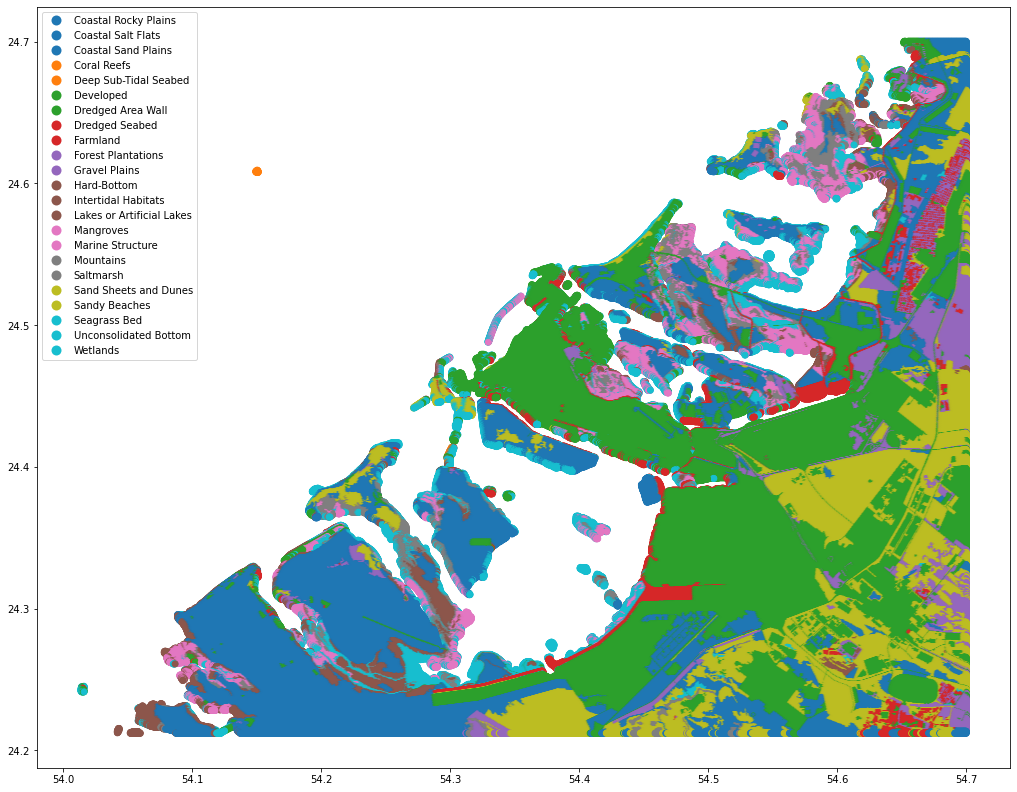

In [19]:
final_combined2.plot(column='Habitats', legend='True')
fig = plt.gcf()
fig.set_size_inches(20, 14)

# 2. gpd.overlay()

In [13]:
final_overlay = gpd.overlay(elevation_shpf_crs, soa_shape_map_geo, how='intersection')
final_overlay.dropna()

,row,col,value,x,y,OBJECTID,Id,HabitatTyp,HabitatT_1,HabitatSub,HabitatS_1,RuleID,Shape_Leng,Shape_Area,Habitats,geometry
0,0,2347,1.0,54.651806,24.700139,25179,25183,9000,"Urban, Industrial And Commercial Habitat Types",9230,Port Areas,49,6946.566553,656876.971787,Developed,POINT (54.65181 24.70014)
1,0,2348,0.0,54.652084,24.700139,25179,25183,9000,"Urban, Industrial And Commercial Habitat Types",9230,Port Areas,49,6946.566553,656876.971787,Developed,POINT (54.65208 24.70014)
2,0,2349,1.0,54.652361,24.700139,25179,25183,9000,"Urban, Industrial And Commercial Habitat Types",9230,Port Areas,49,6946.566553,656876.971787,Developed,POINT (54.65236 24.70014)
3,0,2350,1.0,54.652639,24.700139,25179,25183,9000,"Urban, Industrial And Commercial Habitat Types",9230,Port Areas,49,6946.566553,656876.971787,Developed,POINT (54.65264 24.70014)
4,0,2351,2.0,54.652917,24.700139,25179,25183,9000,"Urban, Industrial And Commercial Habitat Types",9230,Port Areas,49,6946.566553,656876.971787,Developed,POINT (54.65292 24.70014)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786761,1757,2380,37.0,54.660973,24.212083,24114,24118,9000,"Urban, Industrial And Commercial Habitat Types",9120,Low Density Urban,46,682.850742,19713.846374,Developed,POINT (54.66097 24.21208)
1786762,1757,1564,2.0,54.434306,24.212083,25462,25466,9000,"Urban, Industrial And Commercial Habitat Types",9240,Other Industry,50,838.175126,32194.428201,Developed,POINT (54.43431 24.21208)
1786763,1757,1565,3.0,54.434584,24.212083,25462,25466,9000,"Urban, Industrial And Commercial Habitat Types",9240,Other Industry,50,838.175126,32194.428201,Developed,POINT (54.43458 24.21208)
1786764,1757,2227,29.0,54.618473,24.212083,20323,20327,8000,"Oases, Farmland And Forestry",8300,Livestock Areas,43,1183.466793,43927.977353,Farmland,POINT (54.61847 24.21208)


<AxesSubplot:>

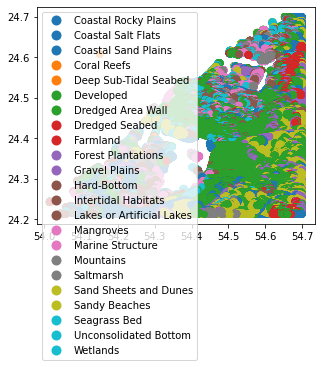

In [14]:
final_overlay.plot(column='Habitats', legend='True')

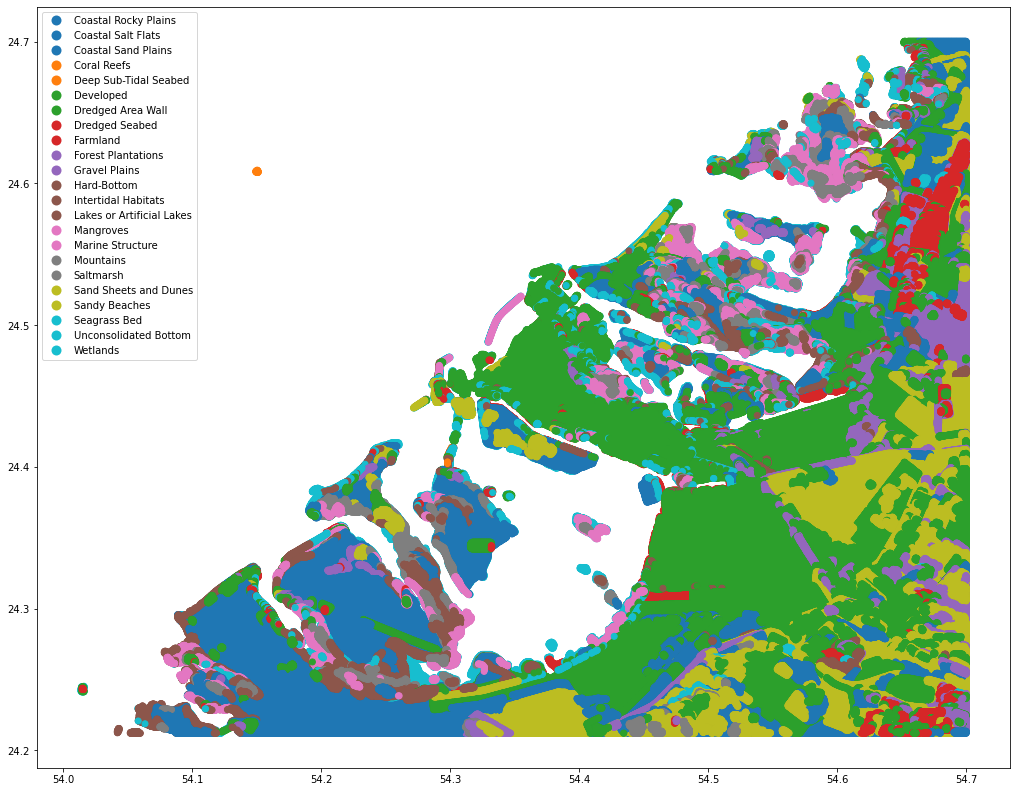

In [20]:
final_overlay.plot(column='Habitats', legend='True')
fig = plt.gcf()
fig.set_size_inches(20, 14)

# Just to be sure:

<AxesSubplot:>

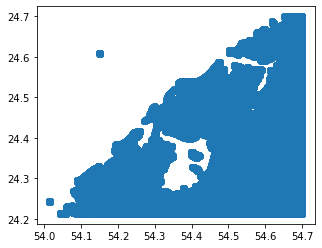

In [15]:
final_combined.plot()

<AxesSubplot:>

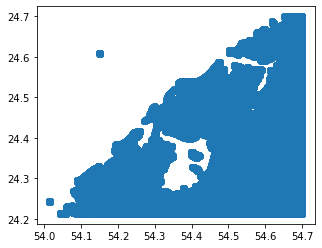

In [16]:
final_overlay.plot()

<AxesSubplot:>

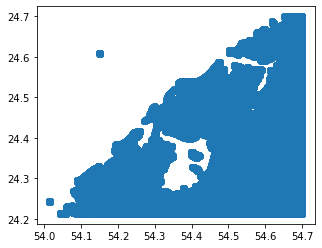

In [17]:
elevation_shpf_crs.plot()

# Saving:

In [22]:
type(final_overlay)

geopandas.geodataframe.GeoDataFrame

In [24]:
final_combined2.to_file('Data/Final_Combined2.shp', driver='ESRI Shapefile')

In [25]:
test_final1 = gpd.read_file('Data/Final_Combined2.shp')
print(type(test_final1))

<class 'geopandas.geodataframe.GeoDataFrame'>


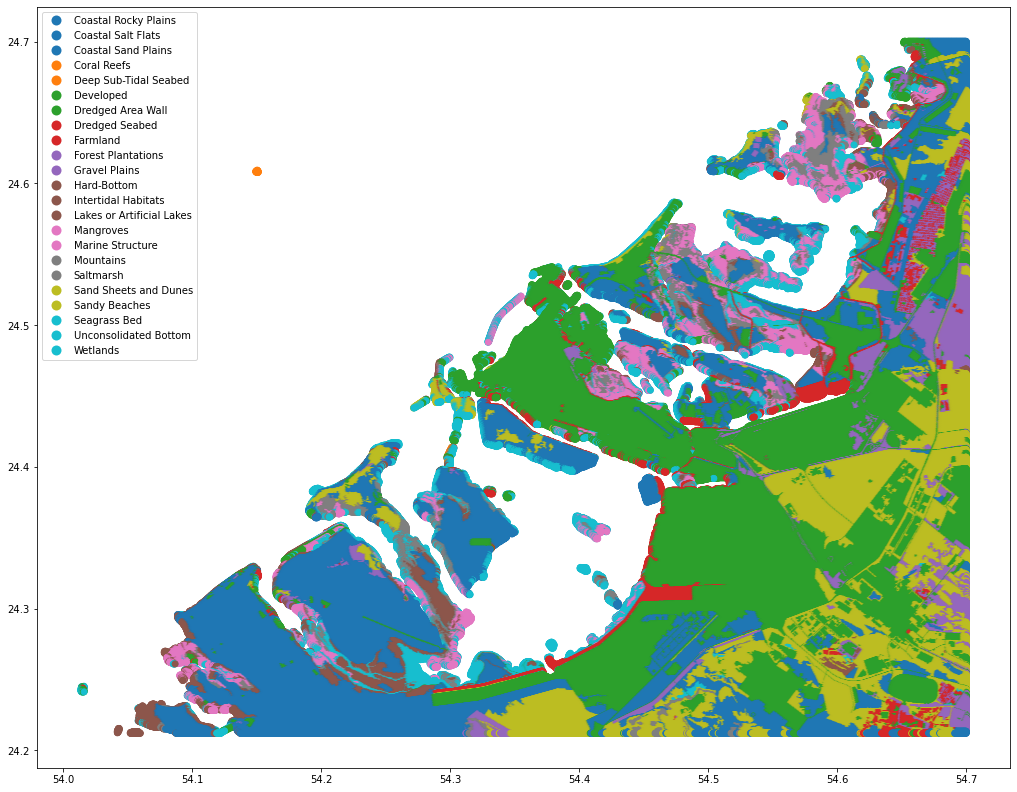

In [26]:
test_final1.plot(column='Habitats', legend='True')
fig = plt.gcf()
fig.set_size_inches(20, 14)

In [27]:
final_overlay.to_file('Data/Final_Overlay.shp', driver='ESRI Shapefile')

In [28]:
test_final2 = gpd.read_file('Data/Final_Overlay.shp')
print(type(test_final2))

<class 'geopandas.geodataframe.GeoDataFrame'>


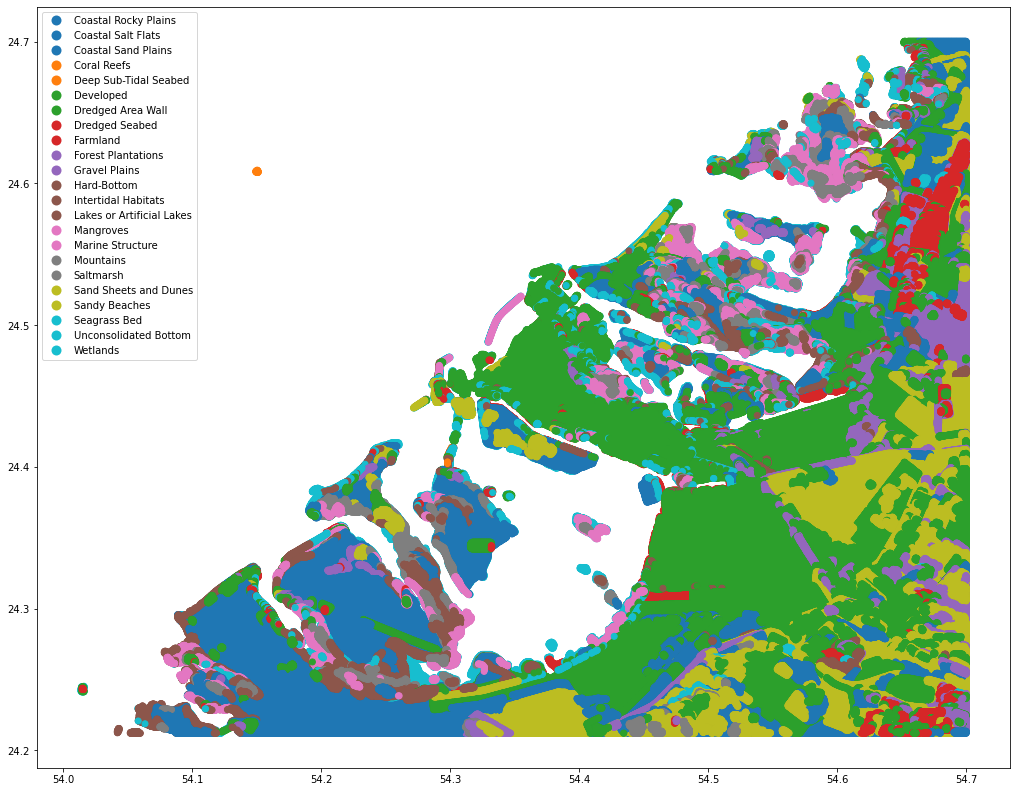

In [29]:
test_final2.plot(column='Habitats', legend='True')
fig = plt.gcf()
fig.set_size_inches(20, 14)